# Técnicas básicas de la minería de datos, Fundamentos de Inteligencia de Negocios

## Grupo: Los ETL

### Integrantes:
- Campos Acevedo Gilberto Eduardo — 00229220  
- Cañas Castillo Adrián Isaac — 00095123  
- Duque Pacheco Luis Fernando — 00013423  
- Hernández Milán José Luis — 00144723  
- Herrera Salinas Jonathan Alcides — 00379823  

### Conexión a Spark 
Preparamos el entorno de PySpark, para luego hacer el analisis.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DataMiningBI").getOrCreate()


### Carga de los datos desde un archivo CSV
Ahora realizamos la carga de los datos desde un archivo CSV, donde los almacenaremos en un Data Frame para poder manipularlos y realizar el análisis.

In [5]:
df = spark.read.csv('vehicle_services_and_repair.csv', header = True, inferSchema = True)

### Exploración sobre los datos


In [6]:
print("Total de Registros: ", df.count())
print("Total de Columnas: ", len(df.columns))

Total de Registros:  508
Total de Columnas:  7


In [7]:
df.printSchema()

root
 |-- CUSTOMER ID: integer (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- SERVICE HISTORY: string (nullable = true)
 |-- COMMON PROBLEM: string (nullable = true)
 |-- SOLUTION USED: string (nullable = true)
 |-- VEHICAL COMPANY: string (nullable = true)



El resultado de **df.printSchema()** nos muestra la estructura interna del DataFrame: cada columna aparece listada bajo el nodo raíz, junto con su tipo de dato y si puede admitir valores nulos o no.

In [8]:
df.show(5, truncate =  False)

+-----------+------------+--------------+-------------------------------+-------------------+-----------------------+-------------------+
|CUSTOMER ID|CITY        |STATE         |SERVICE HISTORY                |COMMON PROBLEM     |SOLUTION USED          |VEHICAL COMPANY    |
+-----------+------------+--------------+-------------------------------+-------------------+-----------------------+-------------------+
|1          |Ananthapuram|Andhra Pradesh|Oil Change; Brake Repair       |Brake noise        |Brake pad replacement  | Maruti Suzuki     |
|2          |Ananthapuram|Andhra Pradesh|Engine Repair; Tire Rotation   |Engine overheating |Radiator replacement   | Hyundai           |
|3          |Ananthapuram|Andhra Pradesh|Bodywork; Paint Job            |Dents and scratches|Body repair and repaint|Tata Motors        |
|4          |Ananthapuram|Andhra Pradesh|Oil Change; General Maintenance|Oil leak           |Oil seal replacement   |Mahindra & Mahindra|
|5          |Ananthapuram|Andhra P

Al utilizar **df.show(5, truncate=False)** obtenemos una vista previa completa de las primeras cinco filas de nuestro DataFrame, sin recortar ningún campo de texto. Esto nos permite:

Ver el formato real de valores en cada columna (por ejemplo, cómo vienen separados los servicios en SERVICE_HISTORY o posibles espacios y mayúsculas en CITY y STATE).

Comprobar de forma rápida si existen inconsistencias de formato que se deberán corregir durante el análisis.

### Registros duplicados en los datos

In [9]:
from pyspark.sql.functions import * 

In [10]:
dup_ids = (df.groupBy("CUSTOMER ID")
              .count()
              .filter(col("count") > 1)
 )

print("IDs de registros duplicados")
dup_ids.show(truncate = False)

IDs de registros duplicados
+-----------+-----+
|CUSTOMER ID|count|
+-----------+-----+
|377        |3    |
|376        |3    |
|378        |3    |
|379        |3    |
+-----------+-----+



Al ejecutar **dup_ids.show()** obtenemos la lista de IDs repetidos junto con su número de apariciones, lo que nos facilitará la detección y cuantificación de las duplicidades antes de proceder a su limpieza.

In [11]:
df.filter(col("CUSTOMER ID").isin([377,376,378,379])).orderBy("CUSTOMER ID").show(truncate = False)

+-----------+-------------+---------------+---------------------------------------+-----------------+------------------------+---------------+
|CUSTOMER ID|CITY         |STATE          |SERVICE HISTORY                        |COMMON PROBLEM   |SOLUTION USED           |VEHICAL COMPANY|
+-----------+-------------+---------------+---------------------------------------+-----------------+------------------------+---------------+
|376        | Ananthapuram| Andhra Pradesh| Suspension Repair; General Maintenance| Steering issues | Suspension adjustment  | Tata Motors   |
|376        | Ananthapuram| Andhra Pradesh| Suspension Repair; General Maintenance| Steering issues | Suspension adjustment  | Tata Motors   |
|376        | Ananthapuram| Andhra Pradesh| Suspension Repair; General Maintenance| Steering issues | Suspension adjustment  | Tata Motors   |
|377        | Ananthapuram| Andhra Pradesh| Tire Rotation; Brake Service          | Tire wear       | Tire rotation          | Kia           |

Luego, de ejecutar la linea de codigo anterior, obtenemos la visualización de los registros duplicados. Para luego proceder a su limpieza.

#### Eliminación de registros duplicados

Este bloque elimina todos los registros que comparten el mismo CUSTOMER ID, conservando únicamente la primera aparición de cada cliente, y a continuación muestra el número total de filas resultantes en df_clean, lo que nos permite confirmar cuántos registros únicos por cliente existen tras la deduplicación.

In [12]:
df_clean = df.dropDuplicates(["CUSTOMER ID"])

print("Registros sin duplicidad: ", df_clean.count())

Registros sin duplicidad:  500


### Detección de valores atípicos
Ahora procederemos a detectar valores atípicos, Estos valores atípicos indican que tipos de problema ocurren mucho más frecuentemente que la mayoría de los otros problemas, y por tanto son los puntos críticos donde se deberá centrar primero los esfuerzos de diagnóstico o de optimización de soluciones.

Para ello, usaremos el siguiente criterio para detectar un valor atípico:


Sea $X$ la lista de conteos de frecuencia de cada categoría.

1.  **Cuartiles**  
    - $Q_1$: percentil 25 (primer cuartil).  
    - $Q_3$: percentil 75 (tercer cuartil).

2.  **Rango intercuartílico (IQR)**  
    $
      \mathrm{IQR} = Q_3 - Q_1
    $

3.  **Límites para detectar valores atípicos**  
    $
      L_{\text{inf}} = Q_1 - 1.5 \times \mathrm{IQR},
      \quad
      L_{\text{sup}} = Q_3 + 1.5 \times \mathrm{IQR}
    $

4.  **Criterio para identificar un valor atípico**  
    Un valor $x$ se considera atípico si:
    $
      x < L_{\text{inf}}
      \quad\text{o}\quad
      x > L_{\text{sup}}.
    $


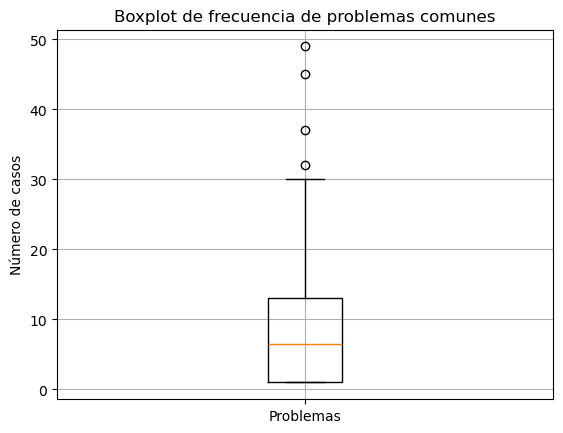

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df_pd = df_clean.toPandas()
counts = df_pd['COMMON PROBLEM'].str.strip().str.lower().value_counts().values

plt.figure()
plt.boxplot(counts)
plt.title('Boxplot de frecuencia de problemas comunes')
plt.ylabel('Número de casos')
plt.xticks([1], ['Problemas'])
plt.grid(True)
plt.show()

En la gráfica se logra visualizar mediante un boxplot la distribución de frecuencias de cada tipo de problema, obtenemos una visión clara de la variabilidad y la concentración de incidencias: la posición de la mediana y el rango intercuartílico nos indican el comportamiento “típico” de los reportes, mientras que los valores atípicos destacan aquellos problemas que ocurren con mucha más frecuencia que el resto. Este análisis facilita la identificación de problemas críticos y la priorización de recursos, pues podemos centrar esfuerzos de diagnóstico y mantenimiento en las categorías que realmente impactan de forma desproporcionada.

Como se observa en la gráfica, hay 4 problemas que tienen mayor número de casos, por lo que será útil conocer cuales son, así que al ejecutar las siguientes lineas de código obtendremos en un tabla con los nombres y la cantidad exacta.

In [14]:
_counts = df_pd['COMMON PROBLEM'].str.strip().str.lower().value_counts()

Q1 = _counts.quantile(0.25)
Q3 = _counts.quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

outliers = _counts[_counts > threshold].reset_index()
outliers.columns = ['COMMON_PROBLEM', 'count']

# Mostrar en tabla
outliers

,COMMON_PROBLEM,count
0,cloudy headlights,49
1,brake noise,45
2,exhaust noise,37
3,tire wear,32


### Top 5 servicios mas utilizados



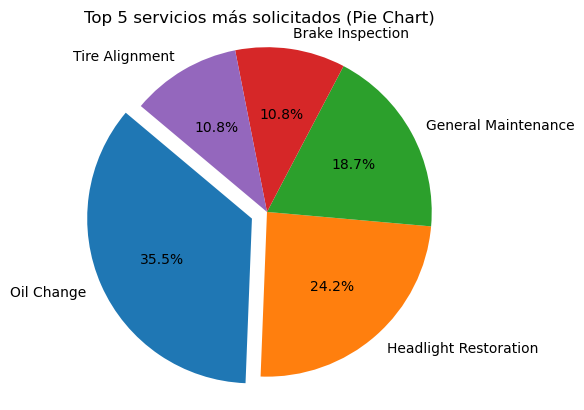

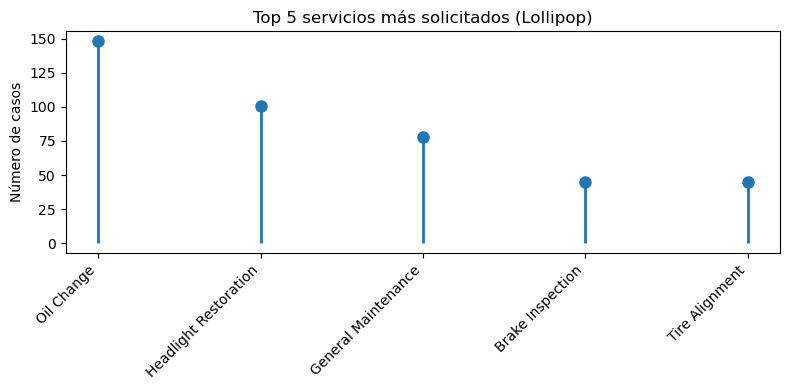

In [15]:

df_pd['SERVICE'] = df_pd['SERVICE HISTORY'].str.split('; ')
df_explode = df_pd.explode('SERVICE')
service_counts = df_explode['SERVICE'].str.strip().value_counts().head(5)

labels = service_counts.index.tolist()
sizes = service_counts.values
explode = [0.1] + [0] * (len(sizes) - 1)

# Pie chart
plt.figure()
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 servicios más solicitados (Pie Chart)')
plt.axis('equal')
plt.show()

# Lollipop chart
plt.figure(figsize=(8, 4))
x = list(range(len(labels)))
markerline, stemlines, baseline = plt.stem(x, sizes, basefmt=" ")
plt.setp(markerline, marker='o', markersize=8)
plt.setp(stemlines, linewidth=2)
plt.xticks(x, labels, rotation=45, ha='right')
plt.title('Top 5 servicios más solicitados (Lollipop)')
plt.ylabel('Número de casos')
plt.tight_layout()
plt.show()

Este análisis desglosa el historial de servicios de cada cliente para identificar las cinco intervenciones más demandadas y presenta los resultados de dos maneras complementarias. El **gráfico circular** revela de un vistazo qué porcentaje del volumen total corresponde a cada servicio, destacando claramente el más popular, mientras que el **lollipop chart** muestra las cifras absolutas de manera ordenada y fácilmente comparable. Con esta información, el equipo de operaciones puede diseñar paquetes de mantenimiento basados en la demanda real, asignar personal y materiales de forma más eficiente, e incluso lanzar ofertas específicas o campañas de venta cruzada centradas en los servicios que generan mayor interés entre los clientes.


### Mapa de calor de casos por Vehiculo

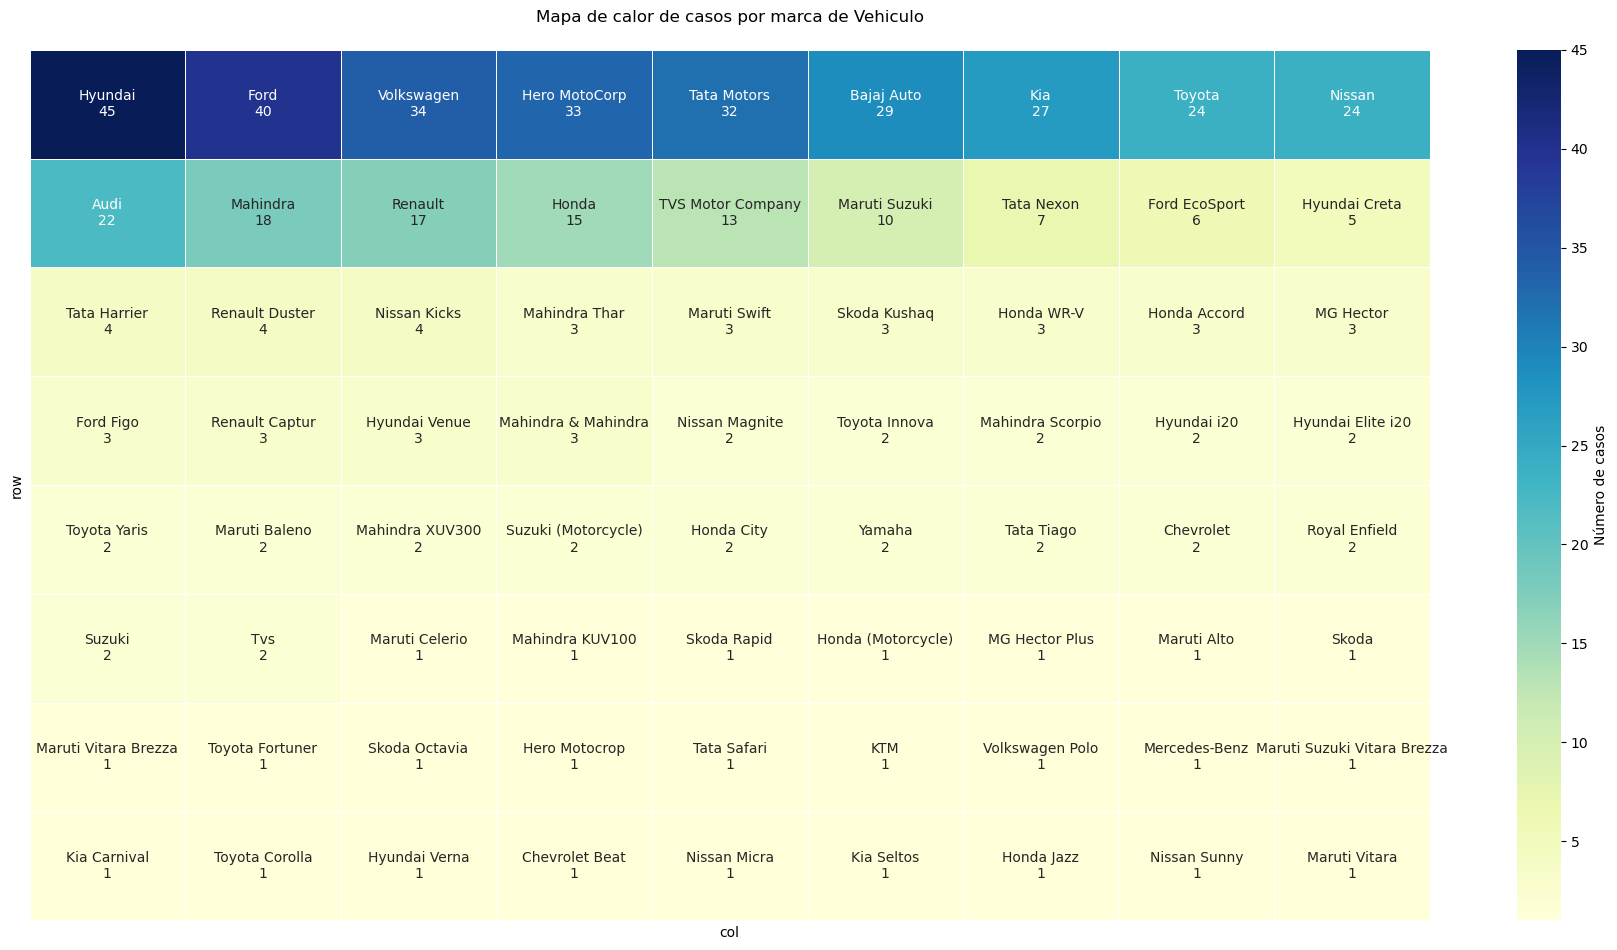

In [16]:
import math
import seaborn as sns

# Conteo por compañía
counts = df_pd['VEHICAL COMPANY'].str.strip().value_counts().reset_index()
counts.columns = ['company', 'count']

# Determinar tamaño de grid
n = len(counts)
n_cols = int(math.ceil(math.sqrt(n)))
n_rows = int(math.ceil(n / n_cols))

# Asignar posición en grid
counts['row'] = counts.index // n_cols
counts['col'] = counts.index % n_cols

# Pivot para valores y compañías
count_matrix = counts.pivot(index='row', columns='col', values='count')
company_matrix = counts.pivot(index='row', columns='col', values='company')

# Crear matriz de anotaciones con nombre y valor
annot_matrix = company_matrix.astype(str) + "\n" + count_matrix.astype(int).astype(str)

# Plot
f, ax = plt.subplots(figsize=(n_cols * 2, n_rows * 1.2))
sns.heatmap(
    count_matrix,
    annot=annot_matrix,
    fmt='',
    linewidths=.5,
    cmap='YlGnBu',
    cbar_kws={'label': 'Número de casos'},
    annot_kws={'fontsize': 10, 'ha': 'center', 'va': 'center'},
    ax=ax
)
ax.set_title('Mapa de calor de casos por marca de Vehiculo', pad=20)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

El mapa de calor nos permite visualizar el volumen de casos asociados a cada marca de vehículo, combinando el nombre de la marca y su recuento dentro de cada celda. Al contrastar colores y valores numéricos, podemos identificar rápidamente qué fabricantes concentran la mayor demanda de servicios y aquellas con menor actividad. Esta presentación facilita la toma de decisiones estratégicas, desde la planificación de inventario y repuestos para las marcas más populares hasta el diseño de campañas de fidelización específicas para los segmentos con menor volumen, optimizando recursos y maximizando el retorno de inversión en mantenimiento.


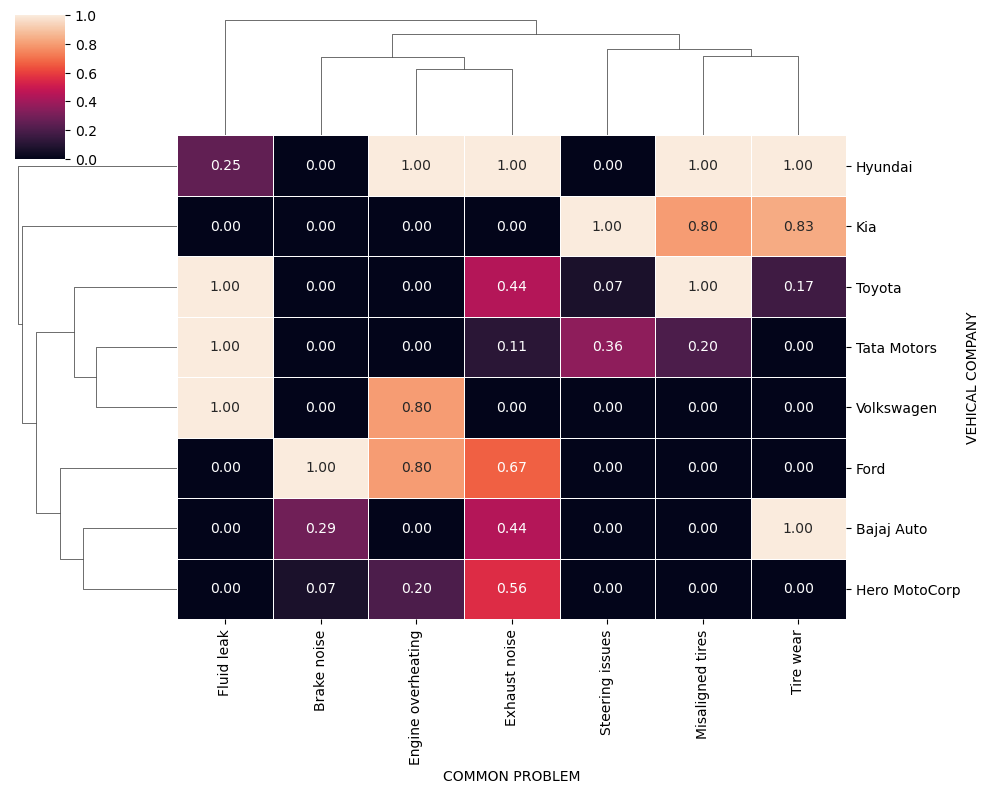

In [17]:
top_companies = df_pd['VEHICAL COMPANY'].str.strip().value_counts().head(8).index.tolist()
top_problems = df_pd['COMMON PROBLEM'].str.strip().value_counts().head(8).index.tolist()

sub_df = df_pd[
    df_pd['VEHICAL COMPANY'].str.strip().isin(top_companies) & 
    df_pd['COMMON PROBLEM'].str.strip().isin(top_problems)
]

pivot = pd.crosstab(
    sub_df['VEHICAL COMPANY'].str.strip(), 
    sub_df['COMMON PROBLEM'].str.strip()
)

g = sns.clustermap(
    pivot, 
    cmap='rocket', 
    linewidths=0.5, 
    figsize=(10, 8), 
    standard_scale=1,
    annot=True, fmt=".2f"
)

El clustermap anterior muestra, de manera simultánea, cómo se distribuyen los ocho problemas más frecuentes entre las ocho marcas de vehículo con mayor actividad en nuestro dataset. En el eje vertical figuran las marcas (por ejemplo, Hyundai, Ford, Toyota), y en el horizontal aparecen los tipos de avería (como “brake noise” o “cloudy headlights”). Cada celda está coloreada según la proporción de ese problema dentro de la marca—tonos rojizos indican una incidencia por encima de la media de la fila (es decir, ese fallo es particularmente común en esa marca), mientras que los tonos azulados señalan frecuencias por debajo de lo habitual.

Los dendrogramas que rodean la matriz (a la izquierda y en la parte superior) agrupan juntas aquellas marcas y averías que comparten patrones similares. Por ejemplo, si Hyundai y Ford aparecen unidos en un mismo clúster, significa que tienden a presentar un perfil de fallos muy parecido; del mismo modo, problemas como “exhaust noise” y “engine stalling” pueden agruparse porque suelen coexistir en varias marcas.

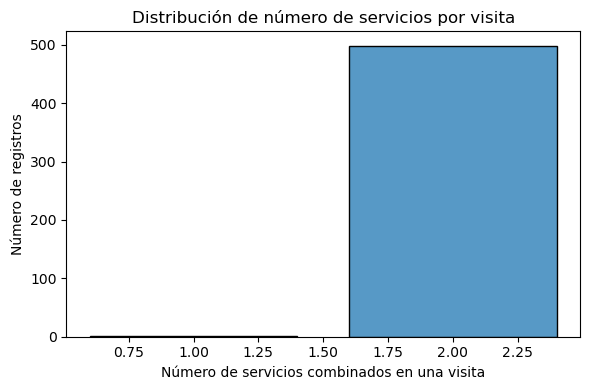

In [18]:
df_pd['num_services'] = df_pd['SERVICE HISTORY'].str.count(';') + 1

plt.figure(figsize=(6, 4))
sns.histplot(data=df_pd, x='num_services', discrete=True, shrink=0.8)
plt.title('Distribución de número de servicios por visita')
plt.xlabel('Número de servicios combinados en una visita')
plt.ylabel('Número de registros')
plt.tight_layout()
plt.show()

El histograma anterior visualiza la cantidad de servicios que los clientes combinan en cada visita. Al contar cuántas veces aparece el separador “;” en la columna SERVICE HISTORY y sumar uno, obtenemos el número total de intervenciones que se realizan simultáneamente. El histograma resultante nos muestra que la gran mayoría de los registros corresponden a una o dos operaciones por visita, mientras que muy pocas abarcan tres o más servicios.

## Modelo de aprendizaje Automatico "Random Forest Classifier"
Random Forest Classifier es un algoritmo de ensamble supervisado que construye múltiples árboles de decisión a partir de subconjuntos aleatorios de los datos y de las variables, y obtiene su predicción final mediante votación mayoritaria de todos los árboles. Funciona entrenando cada árbol con una muestra bootstrap distinta y seleccionando aleatoriamente características en cada nodo, lo que reduce la correlación entre árboles y mejora la generalización. Entre sus beneficios destacan su alta precisión, robustez frente al ruido o valores faltantes, capacidad para manejar variables tanto numéricas como categóricas sin necesidad de transformaciones complejas, y menor riesgo de sobreajuste gracias al promedio de resultados de múltiples modelos independientes.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df_pd.drop(['CUSTOMER ID', 'SOLUTION USED'], axis=1)
y = df_pd['SOLUTION USED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

text_feature = 'SERVICE HISTORY'
cat_features = ['CITY', 'STATE', 'COMMON PROBLEM', 'VEHICAL COMPANY']

preprocessor = ColumnTransformer([
    ('svc', CountVectorizer(tokenizer=lambda s: s.split('; ')), text_feature),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))


/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.88


In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print('CV accuracy mean:', scores.mean(), 'std:', scores.std())

nuevo = {
    'SERVICE HISTORY': 'Oil change; Tire rotation',
    'CITY': 'San Salvador',
    'STATE': 'San Salvador',
    'COMMON PROBLEM': 'Engine noise',
    'VEHICAL COMPANY': 'Toyota'
}

nuevo_df = pd.DataFrame([nuevo])
prediccion = pipeline.predict(nuevo_df)
print('Predicción de SOLUTION USED para el nuevo registro:', prediccion[0])


[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CV accuracy mean: 0.9339999999999999 std: 0.016248076809271893
Predicción de SOLUTION USED para el nuevo registro: Tire rotation and balancing


**Explicación de los resultados obtenidos**

- **Matriz de confusión**  
  La matriz muestra en el eje vertical las etiquetas verdaderas y en el horizontal las predichas. Cada celda (i,j) indica cuántos ejemplos de la clase _i_ fueron asignados a la clase _j_. Los valores altos en la diagonal principal evidencian que la mayoría de instancias se clasificaron correctamente, mientras que los valores fuera de ella señalarían confusiones entre categorías específicas.
- **Precisión en validación cruzada**  
  El `cross_val_score` arrojó una precisión media de **0.934** con una desviación estándar de **0.016**.  
  - Una media tan alta indica que el modelo generaliza bien sobre diferentes particiones de los datos.  
  - La desviación estándar relativamente baja (≈ 1.6 %) confirma que el rendimiento es consistente y no depende de una partición específica.

- **Predicción de un nuevo registro**  
  Para el caso de prueba  
  ```python
  {'SERVICE HISTORY': 'Oil change; Tire rotation',
   'CITY': 'San Salvador',
   'STATE': 'San Salvador',
   'COMMON PROBLEM': 'Engine noise',
   'VEHICAL COMPANY': ' T

Obtenemos una respuesta coherente, ya que tiene cierta relación el historial de servicios con el problema actual que presenta.